# Filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# from tqdm import tqdm

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

## Discrete Fourier Transform

We have seen that the discrete-time Fourier transform (or discrete-space Fourier transform) is a great tool to understand linear shift-invariant filtering of discrete signal and imaging. On the other hand, it is clear that in a computer we will only ever deal with finite-length signals, and in the case of images, often standardized dimensions. It is natural to ask whether there exists a tool similar to DTFT that is tailor-made for finite-length (finite-support) signals. This is also related to the fact that the frequency $\omega$ in DTFT is continuous: there are uncountably many possible values that it can take between $-\pi$ and $\pi$. But if our images are of size $64 \times 64 = 4096$ then we know that we can choose a 4096-dimensional basis to represent any image as a superposition of elements in that basis. It thus seems wasteful to use superpositions of an uncountable infinity complex exponentials with different frequency to represent such images.[^1]


We'd like to have a Fourier transform for finite-length signals (say of length $N$), which requires only $N$ basis functions, or $N$ frequencies. A natural way to do that is to subdivide $[-\pi, \pi)$ into $N$ intervals of equal length, that is to say, choose the sinusoids with discretized frequencies

$$
  \omega_k = \frac{2\pi}{N}k, \ \text{for} \ k \in \{ 0, 1, \ldots, N - 1 \}.
$$
The corresponding base complex exponentials are the roots of unity. That is, $e^{i \omega_k}$ are the solutions to

$$
  z^N = 1,
$$

equally spaced on the unit circle. Here is an illustration for $N = 8$:

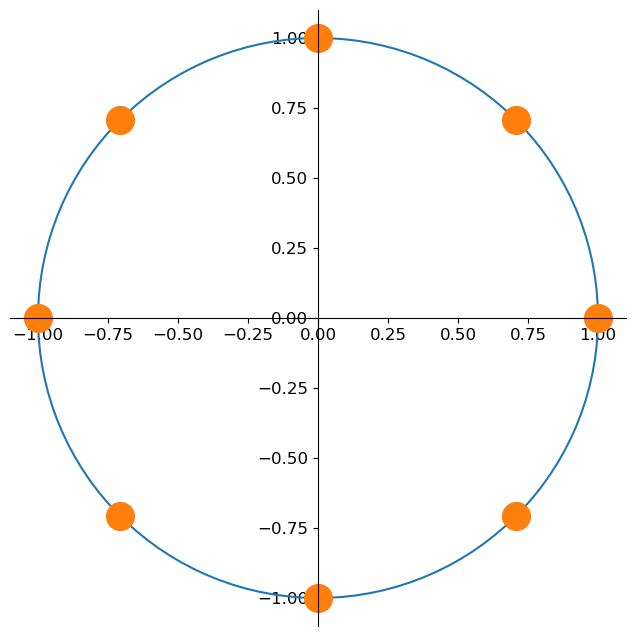

In [2]:
N = 8
angles = np.linspace(0, 2*np.pi, 128, endpoint=True)
root_angles = 2 * np.pi / N * np.arange(N)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.spines[['left', 'bottom']].set_position('center')
ax.spines[['right', 'top']].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(np.cos(angles), np.sin(angles))
ax.plot(np.cos(root_angles), np.sin(root_angles), 'o', markersize=20)
ax.set_aspect(1)

It turns out that such sinusoids are orthogonal. Indeed, denoting $\nu_{k}[n] = e^{i \omega_k n}$, we get that

$$
\begin{aligned}
  \langle \nu_k, \nu_\ell \rangle 
  &= \sum_{n = 0}^{N - 1} \nu_k[n] \nu_\ell[n] \\
  &= \sum_{n = 0}^{N - 1} e^{i \omega_k n} e^{-i \omega_\ell n} \\
  &= \sum_{n = 0}^{N - 1} e^{i \frac{2\pi n}{N} (k - \ell) } \\
  &= (\ast)
\end{aligned}
$$
If $k = \ell$ the exponent is zero and the result is simply $N$. To make progress for $k \neq \ell$ we recall the formula for partial sums of a geometric series,

$$
  \sum_{n = 0}^{N - 1} a^n = \frac{1 - a^N}{1 - a}.
$$

Applying the formula with $a = e^{i \frac{2 \pi (k - \ell)}{N}}$ we get that

$$
  (\ast) 
  = \frac{1 - (e^{i \frac{2 \pi (k - \ell)}{N}})^N} {1 - e^{i \frac{2 \pi (k - \ell)}{N}}}
$$

Now since $(e^{i \frac{2 \pi (k - \ell)}{N}})^N = e^{i 2 \pi (k - \ell)} = 1$ (recall that the complex exponential is $2\pi$-periodic, we see that

$$
   \langle \nu_k, \nu_\ell \rangle 
   =
   \begin{cases}
      N & k = \ell \\
      0 & k \neq \ell.
   \end{cases}
$$

```{admonition} Exercise
Write a code snippet to test this orthogonality numerically.
```

This finally allows us to define the forward and the inverse discrete Fourier transform (DFT) as

$$
  X[k] = \sum_{n = 0}^{N - 1} x[n] e^{-i \frac{2\pi}{N} nk}
  \quad
  \longleftrightarrow
  \quad
  x[n] = \frac{1}{N} \sum_{k = 0}^{N - 1} X[k] e^{i \frac{2\pi}{N} kn}.
$$



## An alternative view of the DFT

Is there an alternative intuitive derivation of the DFT? Sure there is! We can obtain it as a limit DTFT for periodized signals. The math gets a bit involved, especially if you want to do it carefully, so we won't go into the details. But we can write some code. We begin with a simple triangular pulse of $L$ samples:

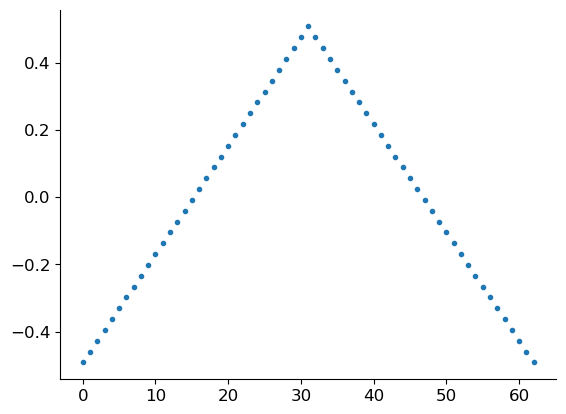

In [3]:
L = 31
n_pulse = np.arange(1 + 2*L)
x = (L - np.abs(n_pulse - L)) / L
x -= x.mean()
plt.plot(n_pulse, x, '.');

Assuming that this pulse is extended by zeros to both infinities we can plot its DTFT.

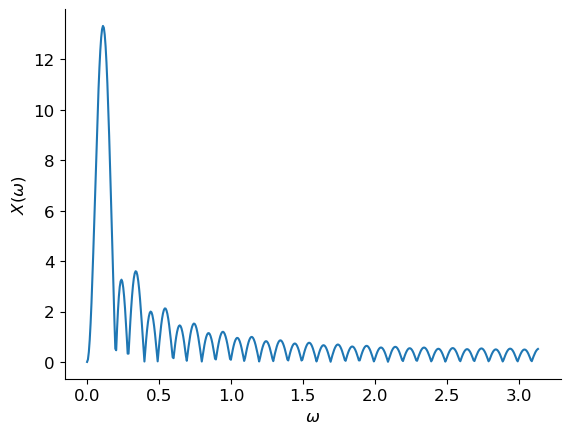

In [4]:
from scipy.signal import freqz

omega, X = freqz(x)
plt.plot(omega, np.abs(X))
plt.xlabel('$\\omega$')
plt.ylabel('$X(\\omega)$');

(We are only showing the spectral magnitude for frequencies $\omega \in [0, \pi)$ since for real-valued signals $x[n]$ we have that $X(-\omega) = X(\omega)^\ast$ so that $|X(-\omega)| = |X(\omega)|$.)

We now construct a _periodic extension_ $\tilde{x}[n]$ of $x[n]$ by repeating $x[n]$ a number of times, and compute its DTFT:

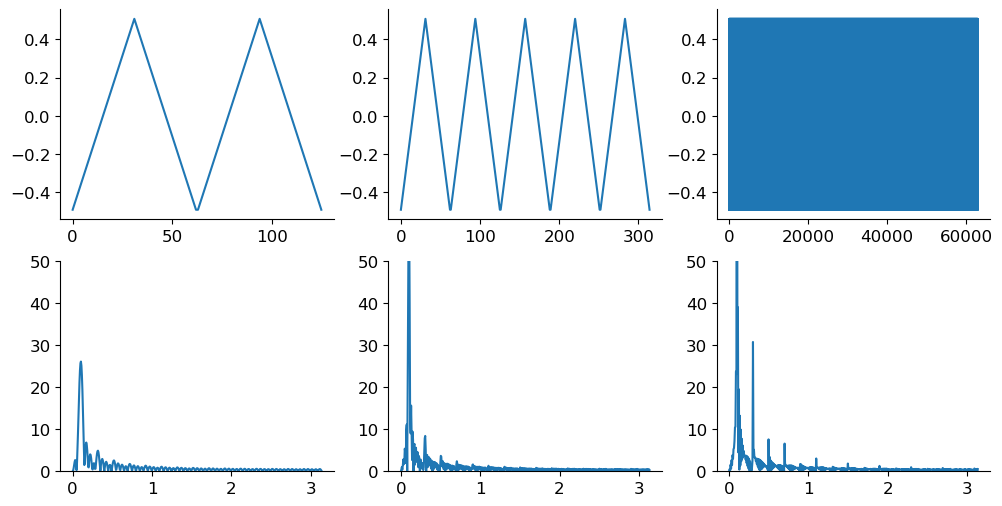

In [5]:
R_list = [2, 5, 1000] # number of repetitions

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for i_R, R in enumerate(R_list):
  x_tilde = np.tile(x, R)
  omega, X_tilde = freqz(x_tilde)
  axs[0, i_R].plot(np.arange(len(x_tilde)), x_tilde)
  axs[1, i_R].plot(omega, np.abs(X_tilde))
  axs[1, i_R].set_ylim(0, 50)

We see that the more periodic repetitions we make, the more discrete the spectrum becomes! With a bit more work we could prove that the spacing between the spectral lines is exactly $2\pi$ divided by the number of samples in one period. (For ease of visualization we plotted the signals as if they were continuous, but they are discrete.)

## Implicit periodization

From the definition of the DFT and the above discussion, we see that the DFT implicitly periodizes the finite-length signals. The expression for the inverse transform,

$$
  x[n] = \frac{1}{N} \sum_{k = 0}^{N - 1} X[k] e^{i \frac{2\pi k}{N} n},
$$

should a priori only make sense for those $n$ where the signal is defined, namely from $0$ to $N - 1$. But there is nothing preventing us from evaluating it elsewhere, whence it indeed follows that

$$
\begin{aligned}
  x[n + N]
  &= \frac{1}{N} \sum_{k = 0}^{N - 1} X[k] e^{i \frac{2\pi k}{N} (n + N)} \\
  &= \frac{1}{N} \sum_{k = 0}^{N - 1} X[k] e^{i \frac{2\pi k}{N} n} e^{i \frac{2\pi k}{N} N} \\
  &= \frac{1}{N} \sum_{k = 0}^{N - 1} X[k] e^{i \frac{2\pi k}{N} n}.
\end{aligned}
$$
Thus with the DFT both the spectrum $X[k]$ and the signal $x[n]$ are implicitly periodic.

 
```{note}
(Warning: puritanism) Strictly speaking we should not use $x[n]$ in the above expression since our starting $x[n]$ is only defined for $n \in \{ 0, \ldots, N - 1\}$. The inverse DFT agrees with $x[n]$ on this interval but is also defined everywhere else.
```


## Circular convolution

We've seen that the DTFT gives us a nice and useful interpretation of convolution in the frequency domain. Do we get the same with the DFT? Well... almost. Since DFT implicitly treats the signals as periodic we have to replace our old definition of convolution by the so-called circular convolution. This just means that when we run out of indices, we wrap around back to the beginning. We'll use the following convenient modulo notation,

$$
  (n)_N = n - N \lfloor n / N \rfloor
$$

which is just the usual modulo-$N$ division. For example, $(7)_8 = 7$, $(8)_8 = 0$, $(9)_8 = 1$.

This yields the definition

$$
  (x \circledast_N h)[n] = \sum_{m = 0}^{N - 1} x[m] h[(n - m)_N].
$$
We will omit the subscript $N$ in $\circledast_N$ when it is clear from context.

With this definition it is not hard to show (do it for fun!) that if $y = x \circledast h$ and $X[k]$, $H[k]$, and $Y[k]$ are the DFTs of $x[n]$, $h[n]$, and $y[n]$, we have

$$
  Y[k] = X[k] H[k].
$$

Conversely, multiplying DFTs of two sequences corresponds to their circular convolution in time (or space when we work with images). This is very important to remember. Unlike forward and inverse DTFT which can only be approximated in a computer by finely discetizing the frequency $\omega$, DFT can be implemented exactly (if we ignore the detail that we cannot represent real numbers with infinite precision). What is more, there exists a very efficient algorithm to compute the DFT of a sequence of length $N$. Naive computation requires to perform a number of operations roughtly proportional to $N^2$. This is because we want to compute $X[k]$ for $N$ different values of $k$, and for each $k$ we have to perform $N$ complex multiplications and sum the results. But the infamous fast Fourier transfrom (FFT) only needs a number of operations proportional to $N \log_2 N$. That is an enormous saving. For $N = 4096$, $N^2 = 16,777,216$ but $N \log_2 N = 49,152$. It is hard to overstate the importance of the FFT in ushering in and maintaining the digital era. This importance stems from the importance of filtering and computing convolutions. Just like naively computing the DFT, naively computing the (circular) convolution takes about $N^2$ operations. But consider this crazy idea: why not first transform both sequences we want to convolve using the FFT ($2 \times N \log N$) then compute the convolution in the DFT domain, which is just multiplication for every $k$ ($N$) and then transform the result back to the time (space) domain ($N \log N$). The overall cost of this dance scales as $N \log N$ and becomes preferable to the direct calculation already for relatively small $N$.

## Linear vs circular convolution

But there is a catch: we almost always want to compute or old _linear_[^2] convolution, not circular. Reverberation in a cathedral is not a cricular phenomenon. We need a way to use the described excursion via the FFT to _emulate_ linear convolution.

Luckily, this is not hard. The idea is to pad the signal with zeros so that the modulo formula does not have to "wrap around". To see how, let again $x[n]$ be a signal of length $N$, and $h[n]$ a "filter" of length $N$. Now recall that the convolution of signals of length $N$ and $L$ has length $N + L - 1$. We thus define a zero-padded version of $x$ as 

$$
  x_{\text{ZP}}[n] 
  = 
  \begin{cases}
    x[n] & n \in \{0, 1, \ldots, N - 1\} \\
    0    & n \in \{N, N + 1, \ldots, 2N - 1\}.
  \end{cases}
$$

It then follows that 

$$  
  (x_{\text{ZP}} \circledast_N h)[n] = (x \ast h)[n], \quad \text{for}~n \in \{0, 1, \ldots, 2N - 1\}.
$$

Zero padding is part of the broader theme of properly handling boundary conditions in convolution.



[^1]: This is even true for infinite-support discrete time/space signals. Since they are indexed by integers $\mathbb{Z}$ or pairs of integers $\mathbb{Z}^2$, they are countable, and thus spanned by bases with much fewer elements than the interval $[-\pi, \pi)$ which has as many elements as the real line.

[^2]: Here, _linear_ is not meant in the sense of a linear system, but in the sense of not being circular. Both "linear" and circular convolution with some filter $h$ and linear operators.